In [22]:
import numpy as np
import pandas as pd
import geopandas as gpd
import importlib
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, CheckboxButtonGroup, CustomJS, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Spectral5
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Colorblind5
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, Span, Legend, LegendItem
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category20, Category20b, Category20c
from math import pi
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

## Table of Contents
* [1. Motivation](#chapter1)
* [2. Basic stats](#chapter2)
* [3. Genre](#chapter4)
* [4. Data Analysis  & Visualizations](#chapter5)
    * [4.1 Current Sales/Trends with Electric Vehicles Worldwide](#section_3_1)
        * [4.1.1 Market Growth](#sub_section_3_1_1)
        * [4.1.2 Fully-electric cars vs. plug-in hybrids](#sub_section_3_1_1)
        * [4.1.3 Top Manufacturers](#sub_section_3_1_1)
    * [4.2 Case Study - Palo Alto](#section_3_2)
        * [4.2.1 Charging station data analysis](#sub_section_3_1_1)
        * [4.2.2 Wassterstein distance - comparison between charging stations](#sub_section_3_1_1)
        * [4.2.3 Start and End charging time distributions](#sub_section_3_1_1)
        * [4.2.4 ML prediction for fee](#sub_section_3_1_1)
* [5. Discussion](#chapter6)
* [6. Contributions](#chapter7)

## 1. Motivation


**What was your goal for the end user's experience?**


The global market for **electric vehicles (EVs)** is undergoing rapid transformation. Growing environmental consciousness and consumer enthusiasm for innovative, eco-friendly technologies are driving widespread EV adoption. However, there are still opportunities to **refine and improve** EV integration for the maximal benefit of both users and the larger energy grid.

In addition, we explore various **social and economic elements** which influence EV manufacturers and sales. Government incentives can significantly increase EV adoption rates. Additionally, the proximity of manufacturing centers, the accessibility of charging stations within a country, and other related **legislation** play critical roles in shaping consumer choices and manufacturer success. For this study, we focus on **main markets** as well as markets with the largest EV adoption such as Norway, seeking to understand the key factors driving success in these regions.

**What is your dataset?
Why did you choose this/these particular dataset(s)?**

For deeper understanding of the problem at a local level, we use city of **Palo Alto**,located in Silicon Valley, California, which provides a unique lens into the dynamics of EV infrastructure.  With high EV ownership and a forward-thinking approach to sustainability, the city presents a valuable **case study** for optimizing  EV usage,  charging patterns, and their impact on local power systems.

- *Peak Demand Understanding*: We do data analysis to understand when the most cars will be charging in Palo Alto. This information is essential for power grid management and stability.
- *Dynamic Fee Estimation*: Create a model that generates fee estimates for EV charging. Fees could change based on expected demand, incentivizing off-peak charging and optimizing power usage.
- *Energy Expenditure Analysis*: Track and analyze EV energy spending to understand the economic contributions of EV owners and potential fluctuations.

In addition, we found several datasets to further encompass a range of economic indicators, market indices, and demographic data from various regions around the world, providing opportunities to conduct comparative analyses, identify cross-border trends, and derive insights that inform strategic decision-making on a global scale.


## 2. Basic Stats

**Write about your choices in data cleaning and preprocessing**

First things we did was to do simple cleaning of NaN values, duplicates and data type convertions into proper datetime and timedelta formats. This is crucial for later analysis of time-based patterns, allowing us to extract temporal insights. Advanced preprocessing steps are with wasserstein distance, where we comapre distributions of each charging station and remove stations which have usage below 28 times, as the average frequency is around 400, and compare distributions visually so they can't affect the predictive models later on. 

In [16]:
data = pd.read_csv('data/EVChargingStationUsage.csv')
data.head(5)

Station Name          MAC Address           Org Name  \
0  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
1  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
2  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
3  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
4  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   

        Start Date Start Time Zone         End Date End Time Zone  \
0  7/29/2011 20:17             PDT  7/29/2011 23:20           PDT   
1   7/30/2011 0:00             PDT   7/30/2011 0:02           PDT   
2   7/30/2011 8:16             PDT  7/30/2011 12:34           PDT   
3  7/30/2011 14:51             PDT  7/30/2011 16:55           PDT   
4  7/30/2011 18:51             PDT  7/30/2011 20:03           PDT   

  Transaction Date (Pacific Time) Total Duration (hh:mm:ss)  \
0                 7/29/2011 23:20                   3:03:32   
1                  7/30/2011 0:02                   0:02:06   
2                 7/30/2011 12:34                   4:17:32   
3                 7/30/2011 16:55                   2:03:24   
4                 7/30/2011 20:03                   1:11:24   

  Charging Time (hh:mm:ss)  ...   Longitude  Currency  Fee  \
0                  1:54:03  ... -122.160309       USD  0.0   
1                  0:01:54  ... -122.160309       USD  0.0   
2                  4:17:28  ... -122.160309       USD  0.0   
3                  2:02:58  ... -122.160309       USD  0.0   
4                  0:43:54  ... -122.160309       USD  0.0   

              Ended By  Plug In Event Id Driver Postal Code  User ID County  \
0  Plug Out at Vehicle                 3            95124.0   3284.0    NaN   
1             Customer                 4            94301.0   4169.0    NaN   
2  Plug Out at Vehicle                 5            94301.0   4169.0    NaN   
3             Customer                 6            94302.0   2545.0    NaN   
4  Plug Out at Vehicle                 7            94043.0   3765.0    NaN   

  System S/N Model Number  
0        NaN          NaN  
1        NaN          NaN  
2        NaN          NaN  
3        NaN          NaN  
4        NaN          NaN  

[5 rows x 33 columns]

In [5]:
column_names = data.columns
print(column_names)

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-null  float64
 12  Ga

In [7]:
data.describe()

Energy (kWh)  GHG Savings (kg)  Gasoline Savings (gallons)  \
count  259415.000000     259415.000000               259415.000000   
mean        8.544277          3.588596                    1.072306   
std         7.185462          3.017894                    0.901776   
min         0.010000          0.004000                    0.001000   
25%         3.784000          1.589000                    0.475000   
50%         6.868634          2.885000                    0.862000   
75%        11.458340          4.813000                    1.438000   
max        97.360000         40.891000                   12.219000   

         Port Number       EVSE ID    Postal Code       Latitude  \
count  259415.000000  1.804670e+05  259415.000000  259415.000000   
mean        1.591627  1.462973e+05   94302.315768      37.439565   
std         0.491534  2.429677e+05       1.941657       0.009621   
min         1.000000  3.792000e+03   94301.000000      37.422104   
25%         1.000000  4.358300e+04   94301.000000      37.428318   
50%         2.000000  1.074270e+05   94301.000000      37.444489   
75%         2.000000  1.745590e+05   94303.000000      37.446613   
max         2.000000  5.535441e+06   94306.000000      37.449375   

           Longitude            Fee  Plug In Event Id  Driver Postal Code  \
count  259415.000000  259415.000000      2.594150e+05       251013.000000   
mean     -122.151264       1.097481      1.188685e+08        94170.308255   
std         0.015382       1.934408      4.057750e+08         4249.837126   
min      -122.163239       0.000000      1.000000e+00         1013.000000   
25%      -122.162170       0.000000      1.573000e+03        94087.000000   
50%      -122.158272       0.000000      3.573000e+03        94304.000000   
75%      -122.145699       1.640000      6.340000e+03        94804.000000   
max      -122.112480      84.560000      1.609436e+09        99354.000000   

         System S/N  
count  1.804670e+05  
mean   1.443790e+11  
std    2.483280e+10  
min    1.023100e+11  
25%    1.231100e+11  
50%    1.427410e+11  
75%    1.705410e+11  
max    2.002410e+11

In [8]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Get unique rows
unique_rows = data.drop_duplicates()
print(f"Number of unique rows: {len(unique_rows)}")

Number of duplicate rows: 4
Number of unique rows: 259411


In [10]:
data = data.drop_duplicates()
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Get unique rows
unique_rows = data.drop_duplicates()
print(f"Number of unique rows: {len(unique_rows)}")

Number of duplicate rows: 0
Number of unique rows: 259411


In [15]:
# Count NaNs/Nulls per column
nan_count_per_column = data.isnull().sum()


In [12]:
data_cleaned = data.dropna()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169443 entries, 78948 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     169443 non-null  object 
 1   MAC Address                      169443 non-null  object 
 2   Org Name                         169443 non-null  object 
 3   Start Date                       169443 non-null  object 
 4   Start Time Zone                  169443 non-null  object 
 5   End Date                         169443 non-null  object 
 6   End Time Zone                    169443 non-null  object 
 7   Transaction Date (Pacific Time)  169443 non-null  object 
 8   Total Duration (hh:mm:ss)        169443 non-null  object 
 9   Charging Time (hh:mm:ss)         169443 non-null  object 
 10  Energy (kWh)                     169443 non-null  float64
 11  GHG Savings (kg)                 169443 non-null  float64
 12  Gas

In [13]:
data_cleaned['Start Date'] = pd.to_datetime(data_cleaned['Start Date'], errors='coerce')
data_cleaned['End Date'] = pd.to_datetime(data_cleaned['End Date'], errors='coerce')
data_cleaned['Transaction Date (Pacific Time)'] = pd.to_datetime(data_cleaned['Transaction Date (Pacific Time)'], errors='coerce')
data_cleaned['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data_cleaned['Total Duration (hh:mm:ss)'])
data_cleaned['Charging Time (hh:mm:ss)'] = pd.to_timedelta(data_cleaned['Charging Time (hh:mm:ss)'])

data_cleaned.head(5)

Station Name          MAC Address            Org Name  \
78948  PALO ALTO CA / CAMBRIDGE #1  0024:B100:0002:1329  City of Palo Alto    
78949  PALO ALTO CA / CAMBRIDGE #2  0024:B100:0002:13B7  City of Palo Alto    
78950  PALO ALTO CA / CAMBRIDGE #1  0024:B100:0002:1329  City of Palo Alto    
78951   PALO ALTO CA / HAMILTON #2  0024:B100:0002:1331  City of Palo Alto    
78952       PALO ALTO CA / HIGH #1  0024:B100:0002:10FE  City of Palo Alto    

               Start Date Start Time Zone            End Date End Time Zone  \
78948 2016-08-01 05:21:00             PDT 2016-08-01 06:49:00           PDT   
78949 2016-08-01 06:01:00             PDT 2016-08-01 10:58:00           PDT   
78950 2016-08-01 06:03:00             PDT 2016-08-01 09:15:00           PDT   
78951 2016-08-01 06:10:00             PDT 2016-08-01 08:54:00           PDT   
78952 2016-08-01 06:13:00             PDT 2016-08-01 09:33:00           PDT   

      Transaction Date (Pacific Time) Total Duration (hh:mm:ss)  \
78948             2016-08-01 06:49:00           0 days 01:27:58   
78949             2016-08-01 10:58:00           0 days 04:56:27   
78950             2016-08-01 09:15:00           0 days 03:12:17   
78951             2016-08-01 08:54:00           0 days 02:44:25   
78952             2016-08-01 09:33:00           0 days 03:19:24   

      Charging Time (hh:mm:ss)  ...   Longitude  Currency  Fee  \
78948          0 days 01:25:26  ... -122.146065       USD  0.0   
78949          0 days 02:31:04  ... -122.146065       USD  0.0   
78950          0 days 03:11:18  ... -122.146065       USD  0.0   
78951          0 days 02:25:49  ... -122.159904       USD  0.0   
78952          0 days 03:19:15  ... -122.162849       USD  0.0   

                  Ended By  Plug In Event Id Driver Postal Code  User ID  \
78948  Plug Out at Vehicle              1665            94587.0   523487   
78949  Plug Out at Vehicle              1771            95030.0   141845   
78950  Plug Out at Vehicle              1666            80525.0   203603   
78951  Plug Out at Vehicle              2093            94539.0   126575   
78952  Plug Out at Vehicle              3112            94024.0   191743   

                   County    System S/N  Model Number  
78948  Santa Clara County  1.427410e+11  CT4020-HD-GW  
78949  Santa Clara County  1.428410e+11  CT4020-HD-GW  
78950  Santa Clara County  1.427410e+11  CT4020-HD-GW  
78951  Santa Clara County  1.427410e+11  CT4020-HD-GW  
78952  Santa Clara County  1.422410e+11  CT4020-HD-GW  

[5 rows x 33 columns]

In [14]:
data_cleaned.info

<bound method DataFrame.info of                        Station Name          MAC Address            Org Name  \
78948   PALO ALTO CA / CAMBRIDGE #1  0024:B100:0002:1329  City of Palo Alto    
78949   PALO ALTO CA / CAMBRIDGE #2  0024:B100:0002:13B7  City of Palo Alto    
78950   PALO ALTO CA / CAMBRIDGE #1  0024:B100:0002:1329  City of Palo Alto    
78951    PALO ALTO CA / HAMILTON #2  0024:B100:0002:1331  City of Palo Alto    
78952        PALO ALTO CA / HIGH #1  0024:B100:0002:10FE  City of Palo Alto    
...                             ...                  ...                 ...   
259409  PALO ALTO CA / CAMBRIDGE #5  0024:B100:0002:9B7F  City of Palo Alto    
259411    PALO ALTO CA / WEBSTER #1  0024:B100:0002:4233  City of Palo Alto    
259412        PALO ALTO CA / MPL #4  0024:B100:0003:CD37  City of Palo Alto    
259413    PALO ALTO CA / WEBSTER #1  0024:B100:0002:4233  City of Palo Alto    
259414  PALO ALTO CA / CAMBRIDGE #4  0024:B100:0003:3A0A  City of Palo Alto    

       

**Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.**

Pre-cleaning data has 259k rows with 33 features, post-cleaning we have 169k rows with the same number of features. Below see the average charging time acompanied by the grid plot, which capture the essence of our user centric approach to the EV charging problem

In [19]:
from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.io import output_notebook
import numpy as np

# Calculate the average frequency of charging per MAC Address
average_frequency = data_cleaned.groupby('MAC Address').size()

# Remove the stations with frequency < 28 -> anomalies
average_frequency = average_frequency[average_frequency > 28]

data_cleaned = data_cleaned[data_cleaned['MAC Address'].isin(average_frequency.index)]
charging_time_minutes = data_cleaned['Charging Time (hh:mm:ss)'].dt.total_seconds() / 60

# Calculate the histogram data
hist, edges = np.histogram(charging_time_minutes, bins=50)

# Create a new figure
p = figure(title='Distribution of Charging Times', x_axis_label='Charging Time (minutes)', y_axis_label='Frequency', width=500, height=400)

# Add a quad glyph for the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='#1f77b4', line_color='black')
# Calculate the average charging time
average_charging_time = charging_time_minutes.mean()

# Add a vertical line at the average charging time
average_line = Span(location=average_charging_time, dimension='height', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(average_line)

# Display the plot
output_notebook()
#output_file("p5.html")
show(p)

Loading BokehJS ...

As can be seen from the plot, the charging time follows a power law distribution with the average charging time of approximately 118 minutes where shorter charging times are more frequent than longer ones. After going through average charging times for electric vehicles we found out that batery charging follows a two-phase process; initially, the charging is fast, followed by a slower phase as the battery approaches full capacity. 

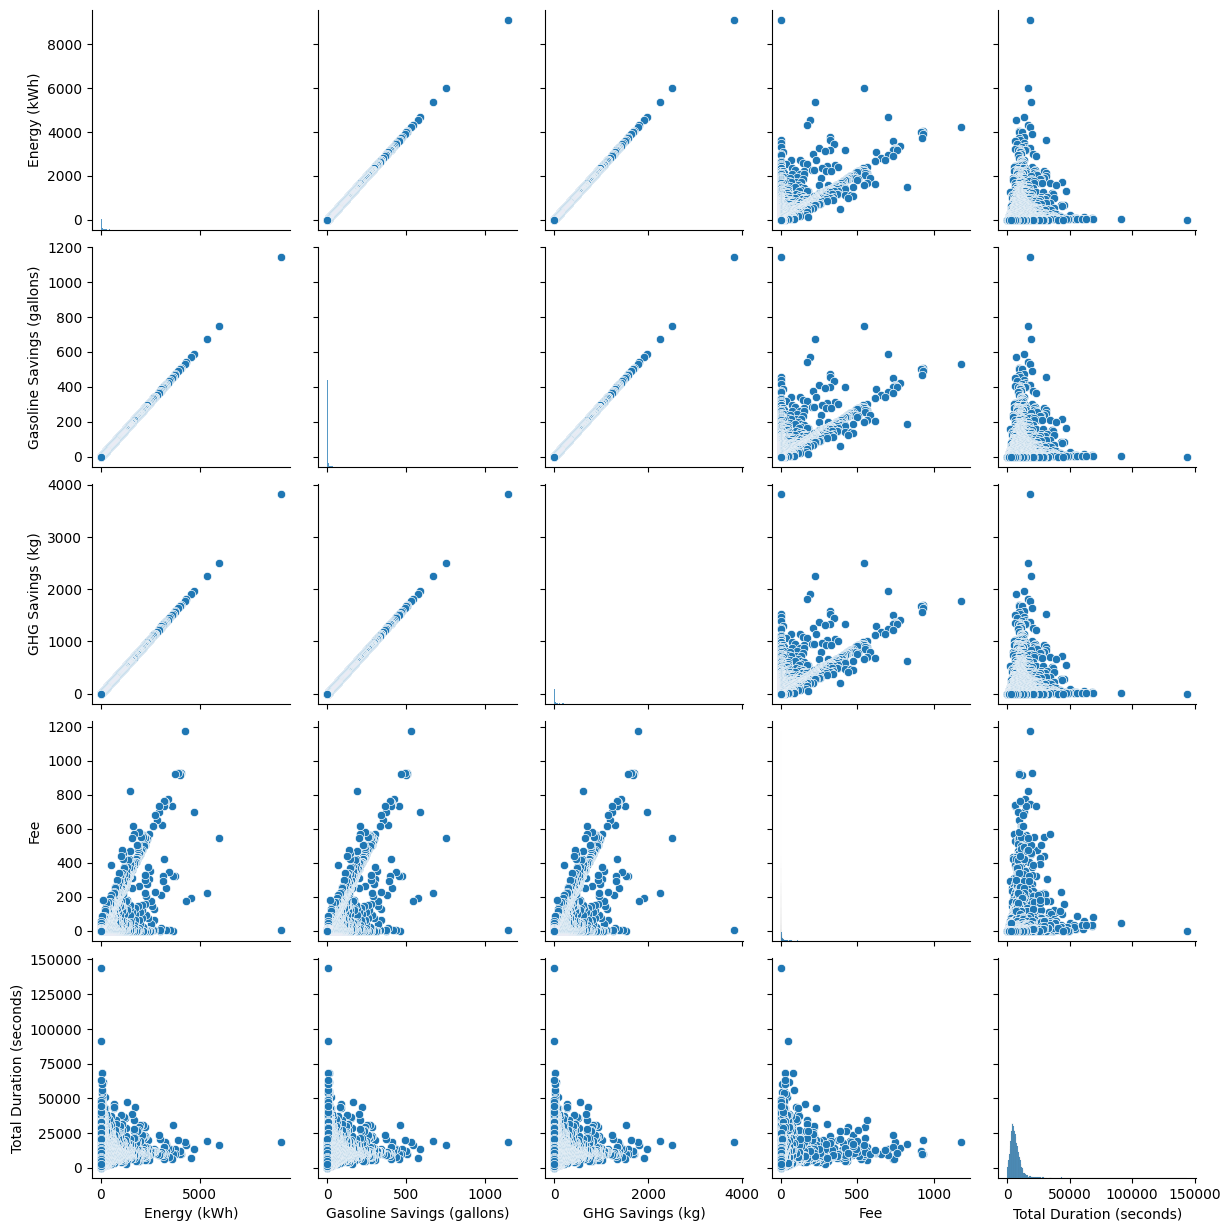

In [23]:
sums = data_cleaned.groupby('User ID')[['Energy (kWh)', 'Gasoline Savings (gallons)', 'GHG Savings (kg)', 'Fee']].sum()

data_cleaned['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data_cleaned['Total Duration (hh:mm:ss)'])
means = data_cleaned.groupby('User ID')['Total Duration (hh:mm:ss)'].mean()

result = pd.concat([sums, means], axis=1)
result_sorted = result.sort_values(by=['Energy (kWh)', 'Gasoline Savings (gallons)', 'Total Duration (hh:mm:ss)'],  ascending=False)
result_sorted['Total Duration (seconds)'] = result_sorted['Total Duration (hh:mm:ss)'].dt.total_seconds()

# Create the pairplot
sns.pairplot(result_sorted)
plt.show()

The analysis reveals a **power law** relationship between total charging duration and energy consumption, with larger EV batteries generally requiring more energy. However, outliers exist where extended charging durations are observed despite minimal energy usage, typically attributable to instances where vehicles **remain plugged in despite already being fully charged**. Identifying and addressing these outliers can enhance the efficiency of charging infrastructure and ensure optimal utilization, ultimately improving our understanding of EV charging behaviors and the effectiveness of charging networks.

Next part is the obvious **linear relationship GHG savings/gasoline savings**, when looking at the data to get one from another just divide by 7.89. However, an interesting is the behaviours of fees. It acts as a linear relationship; however, it is unclear what is going on. Hence, we decided to delve deeper into this data. In the below sectors, we utilize average fee, energy spent, and charging time to understand the trend.

# 3. Data Analysis

**Describe your data analysis and explain what you've learned about the dataset.**

In our data analysis, we employed a combination of statistical techniques, machine learning algorithms, and visualization tools to gain insights from the dataset. What we learned from the datasets, is two-fold: firstly, our Palo alto case-study dataset offers a record of charging activities within the city, providing insights into charging behaviors, energy consumption patterns, and infrastructure utilization among electric vehicle owners. Our main focus is the intersection of charging time, fees and energy spent/gasoiln saved. In the map below you can see the location of each charging station, so our dataset is not only a reference for a single city, but reflects a larger pattern which can be found in any larger city and country.

**If relevant, talk about your machine-learning.**

From a user perspective, what is important are fee, or the price that user is paying/saving compared to using traditional combustion engine. And, since the charging time duration always follows a similar pattern, and does not need prediction element, we use current energy prices combined with average charging time to present the user with the estimated fee he would pay if he started charging immediatelly. In addition, we estimate energy demand using a 30 day lag to predict the next day, giving users additional insight wether charging the next day is optimal.

In [17]:
import folium

# Find unique combinations of 'MAC Address', 'Latitude', and 'Longitude'
unique_locations = data_cleaned[['MAC Address', 'Latitude', 'Longitude']].drop_duplicates()

print("Unique EV Charging locations in the city: ", len(unique_locations))

# Create a map centered at the mean latitude and longitude values
m = folium.Map(location=[data_cleaned['Latitude'].mean(), data_cleaned['Longitude'].mean()], zoom_start=13)

# Add a marker for each unique charger location
for idx, row in unique_locations.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['MAC Address']).add_to(m)
m.save("my_map.html")
# Display the map
m

Unique EV Charging locations in the city:  64


As can be seen from the map, the charging stations are located near Stanford University in the city centre

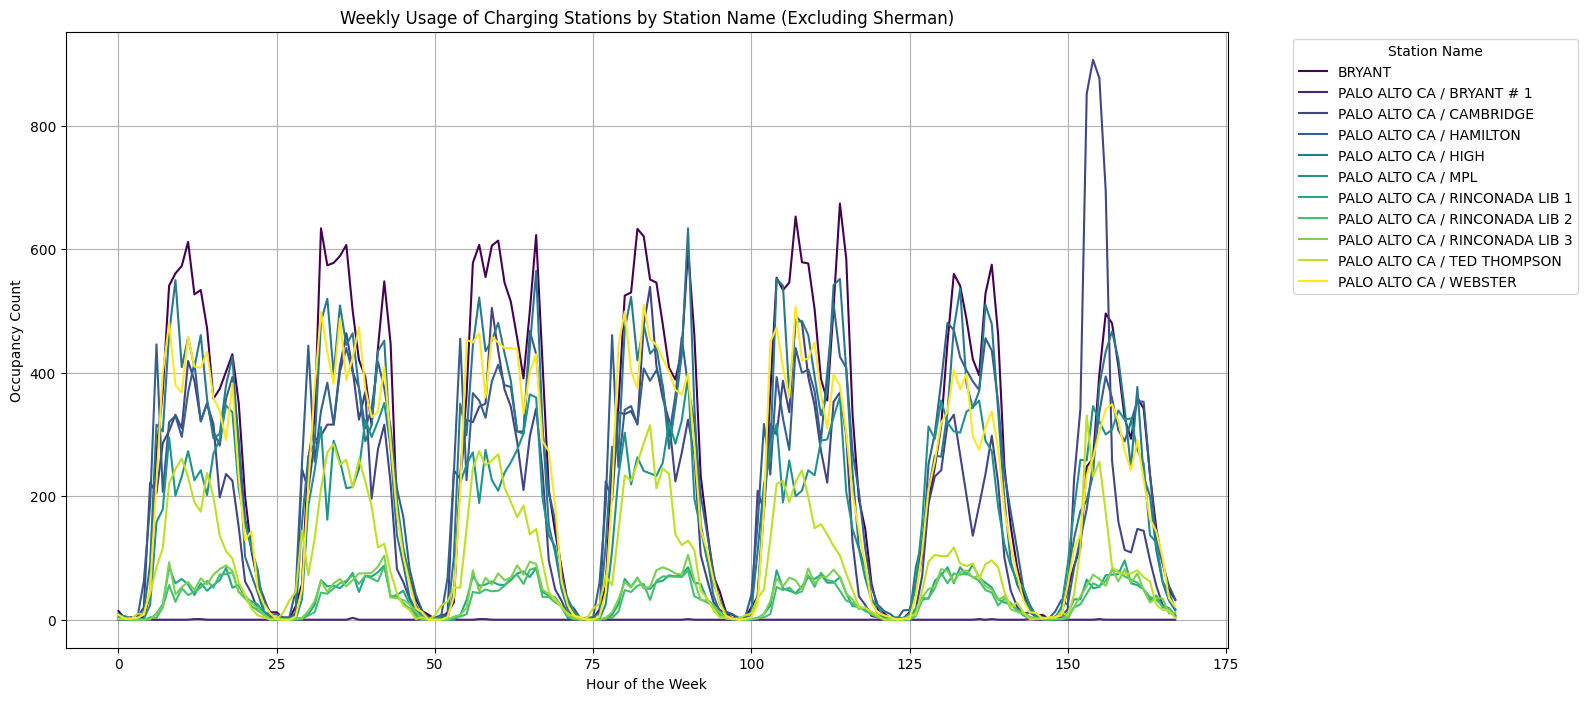

In [26]:
data = pd.read_csv('data/EVChargingStationUsage.csv')

# Convert 'Start Date' to datetime and extract the hour of the week
data['Start DateTime'] = pd.to_datetime(data['Start Date'], format='%m/%d/%Y %H:%M', errors='coerce')
data['Weekday'] = data['Start DateTime'].dt.dayofweek
data['Hour'] = data['Start DateTime'].dt.hour
data['Hour of the Week'] = data['Weekday'] * 24 + data['Hour']

# Generalize station names by removing specific numbers and combining entries
data['Generalized Station Name'] = data['Station Name'].str.replace(r'\s#\d+', '', regex=True)
data['Generalized Station Name'] = data['Generalized Station Name'].replace({
    'PALO ALTO CA / HAMILTON Combined': 'HAMILTON',
    'PALO ALTO CA / BRYANT': 'BRYANT'
})

# Group data by generalized station name and hour of the week, and count occurrences
grouped_data = data.groupby(['Generalized Station Name', 'Hour of the Week']).size().unstack(fill_value=0)

# Exclude 'SHERMAN' related entries
grouped_data = grouped_data.drop([station for station in grouped_data.index if "SHERMAN" in station])

# Create a color palette with a unique color for each station
station_colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_data.index)))

# Plotting
plt.figure(figsize=(15, 8))
for station, color in zip(grouped_data.index, station_colors):
    plt.plot(grouped_data.columns, grouped_data.loc[station], label=station, color=color)

plt.title('Weekly Usage of Charging Stations by Station Name (Excluding Sherman)')
plt.xlabel('Hour of the Week')
plt.ylabel('Occupancy Count')
plt.legend(title='Station Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## 4. Genre

# 5. Visualization

## 5.1 Current Sales/Trends with Electric Vehicles Worldwide
Electric vehicle sales are on the rise globally, as more people is deciding to switch to "greener" forms of transportation. This trend is driven by a growing awareness of environmental issues and a shared interest in eco-friendly technology. It is clear that both the hype around and the actual move toward electric mobility are accelerating, reflecting a collective effort to tackle climate change.

### 5.1.1 Market Growth:

- Sales of electric cars started from a low base but are growing quickly in many markets.
- Globally, around 1-in-4 new cars sold were electric in 2023. In **Norway**, this share was over 90%, and in **China**, it was almost 40%.
- In the following visualization, “electric cars” include fully battery-electric vehicles and plug-in hybrids.

The dataset is about a share of new cars sold that are electric for 13 years period (2010-2023), in other words, how many of total cars sold within a year were EVs. In the following section, USA (where Palo Alto is located) will be compared to Denmark, EU, Noraway and China. 

[1] https://www.iea.org/reports/global-ev-outlook-2023

In [2]:
data=pd.read_csv('data/electric-car-sales-share.csv')

In [3]:
required_countries = ["United States", "European Union (27)", "China", "Denmark", "Norway","World"]
required_countries_data = data[data['Entity'].isin(required_countries)]

output_notebook()
p = figure(title="Electric Car Sales Share Comparison", x_axis_label='Year', y_axis_label='Electric Cars Sales Share (%)', width=500, height=400)

colors = [
    '#1f77b4',  # muted blue
    '#d62728',  # brick red
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
] 
legend_items = []

for i, country in enumerate(required_countries):
    country_data = data[data['Entity'] == country]
    country_data = country_data.sort_values('Year')
    
    X = country_data['Year'][:-1].values.reshape(-1, 1)  # Exclude the last year for prediction
    y = country_data['Share of new cars that are electric'][:-1]
    reg = LinearRegression().fit(X, y)
    #predict the next year's value based on the model
    predicted_value = reg.predict([[country_data['Year'].values[-1] + 1]])
    #test
    line = p.line(x='Year', y='Share of new cars that are electric', source=ColumnDataSource(country_data), color=colors[i], line_width=2, legend_label=country)
    #predicted
    pred_line = p.line(x=[country_data['Year'].values[-1], country_data['Year'].values[-1] + 1], 
                       y=[country_data['Share of new cars that are electric'].values[-1], predicted_value[0]], 
                       color=colors[i], line_width=2, line_dash='dashed', legend_label=country)
    
    legend_items.append((country, [line, pred_line]))

p.legend.click_policy = "hide"
p.legend.location = 'top_left'
p.add_layout(Span(location=country_data['Year'].values[-1], dimension='height', line_dash='dashed', line_color='gray'))
output_file("p1.html")
show(p)

Loading BokehJS ...

From the plot above it can be observed that Norway has the highest share of new cars that are electric by far, compared to other states. Such a result is expected, since Norway is also known for its very generous subsidy for EVs, as explained here https://alternative-fuels-observatory.ec.europa.eu/transport-mode/road/norway/incentives-legislations. Surprisingly, the USA is below the world's average, mostly due to the cheaper gas prices compared to other countries. Interestingly, China surpassed the EU in 2018 but still remained on lower sales than Denmark, which has the highest share of new cars that are electric within the EU.

### 5.1.2 Fully-electric cars vs. plug-in hybrids:

“Electric cars” include battery-electric and plug-in hybrid vehicles. The difference is that fully battery-electric cars do not have an internal combustion engine, whereas plug-in hybrids have a rechargeable battery and electric motor and an internal combustion engine that runs on gasoline.

- Plug-in hybrid could be driven as a standard petrol car if the owner did not charge the battery. 

- The battery in plug-in hybrids is smaller and has a shorter range than battery-electric cars, so over longer distances, the car starts running on gasoline once the battery has run out.

- Since plug-in hybrids will often run on petrol, they tend to emit more carbon than battery-electric cars. However, they do usually have lower emissions than petrol or diesel cars.

In the barcharts below we will compare the share of Battery-electric and Plug-in hybrid cars sold across different states and worldwide.

[2] https://www.iea.org/reports/global-ev-outlook-2023

In [4]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

car_sales_data = pd.read_csv('data/share-car-sales-battery-plugin.csv')
# Grouping data by 'Year' and 'Entity'
car_sales_grouped = car_sales_data.groupby(['Entity', 'Year']).sum().reset_index()
countries = ["United States", "China", "European Union (27)", "Denmark", "Norway", "World"]
output_notebook()

# list to hold the individual plots
plots = []

# Define specific colors
lighter_blue = '#1f77b4'
lighter_red = '#d62728'

# Plot for each country
for i, country in enumerate(countries):
    # Filter the data for the country
    country_sales = car_sales_grouped[car_sales_grouped['Entity'] == country]
    source = ColumnDataSource(country_sales)
    
    # Figure with a title and axis labels
    p = figure(title=f"Share of New Cars Sold in {country} that are Battery-Electric and Plug-in Hybrid",
               x_axis_label='Year', y_axis_label='Share of Cars Sold (%)',
               height=500, width=400, tools="")

    # Stack the bars for 'Battery-electric' and 'Plug-in hybrid'
    p.vbar_stack(['Battery-electric as a share of cars sold', 'Plug-in hybrid as a share of cars sold'],
                 x='Year', width=0.9, color=[lighter_blue, lighter_red], source=source,
                 legend_label=['Battery-electric', 'Plug-in hybrid'])

    p.xaxis.major_label_orientation = 1.57 / 4
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    plots.append(p)

# Grid layout of plots
grid = gridplot(plots, ncols=3)
output_file("p2.html")
show(grid)

Loading BokehJS ...

It can be observed that Norway and Denmark are the only ones from above which have decline of share of Plug-in hybrid cars sold in the last year. In all of the displayed bar plots, the exponential growth of Battery-electric EVs is observed. That implies growing awareness of environmental issues and a shared interest in eco-friendly technology, together with the partial transition towards fully electric cars by a large share of the population represented by Plug-in hybrid sales. Transition to fully electric cars has yet not been established due concernc about vehicle range, and many opt for hybrids or gasoline-fueled vehicles to travel longer distances.

### 4.1.3 Top Manufacturers:

Sales of plug-in electric vehicles (PEVs) grew rapidly from 2011 to 2018. Technology improvements, cost reduction, increasing model choice, maturing charging infrastructure, and economic recovery have continued to influence and support increased sales. Until 2018, the Chevrolet Volt had been on the market the longest and had the most overall sales, but the model was discontinued in 2019. In 2018, the newly introduced Tesla Model 3 rapidly increased vehicle sales and established the vehicle as the best-selling plug-in electric vehicle with nearly 50% of the market share. In the plot below, the top 10 EV manafacturers by total sales for period from 2012-2019 will be displayed.

[3] https://www.anl.gov/esia/light-duty-electric-drive-vehicles-monthly-sales-updates

In [5]:
sales_data = pd.read_csv('data/Electric Car Sales by Model in USA.csv')

output_notebook()

# Make sure you have the correct dataset in 'top_makes_long' before you plot.
for year in range(2012, 2020):
    sales_data[str(year)] = pd.to_numeric(sales_data[str(year)].astype(str).str.replace(',', ''), errors='coerce')

# Group by 'Make' and sum the sales for each year, summing only numeric columns
sales_by_make = sales_data.groupby('Make').sum(min_count=1)

# Now, calculate the 'Total_Sales' for each 'Make' by summing across the numeric year columns only
sales_by_make['Total_Sales'] = sales_by_make[[str(year) for year in range(2012, 2020)]].sum(axis=1)

# Get the top 10 makes by total sales
top_makes = sales_by_make['Total_Sales'].nlargest(10).index.tolist()
top_makes_sales = sales_by_make.loc[top_makes].reset_index()

# Melt the DataFrame to long format for plotting
top_makes_long = pd.melt(top_makes_sales, id_vars=['Make'], var_name='Year', value_name='Sales')


# Convert 'Year' to string for categorical data plotting
top_makes_long['Year'] = top_makes_long['Year'].astype(str)

# Make sure the years are sorted
years_sorted = sorted(top_makes_long['Year'].unique())
years_sorted = [str(year) for year in range(2012, 2020)]

# Create a color map from makes to colors
makes = top_makes_long['Make'].unique().tolist()
colors = Category20[len(makes)] if len(makes) <= 20 else Category20[20] + Category20[len(makes)-20]
make_color = {make: color for make, color in zip(makes, colors)}
# Create a color map from makes to colors
makes = top_makes_long['Make'].unique().tolist()
colors = Category20[len(makes)] if len(makes) <= 20 else Category20[20] + Category20[len(makes) - 20]
make_color = {make: color for make, color in zip(makes, colors)}

output_notebook()
source = ColumnDataSource(top_makes_long)

p = figure(x_range=years_sorted, title="Total Car Sales by Make and Year (Top 10)",
           x_axis_label='Year', y_axis_label='Total Sales', sizing_mode="stretch_width", width=400, height=450)

#lines for each make with a unique color
for make in makes:
    make_data = top_makes_long[(top_makes_long['Make'] == make) & (top_makes_long['Year'].isin(years_sorted))]
    make_source = ColumnDataSource(make_data)
    p.line(x='Year', y='Sales', source=make_source, legend_label=make, color=make_color[make])
    p.circle(x='Year', y='Sales', source=make_source, legend_label=make, color=make_color[make], size=8)

p.legend.location = "left"
p.legend.click_policy = "hide"
p.legend.title = 'Make'
hover = HoverTool()
hover.tooltips = [("Make", "@Make"), ("Sales", "@Sales{0,0}"), ("Year", "@Year")]
p.add_tools(hover)
p.xaxis.major_label_orientation = pi / 4
output_file("p3.html")
show(p)

Loading BokehJS ...

Loading BokehJS ...

From the plot above it can be observed that all the manufacturers have increased sales through the last 10 years. Until 2017 Chevrolet had the most sales, when Tesla took the lead with further exponential growth. That reflects a (closely correlated) share of new EVs sold worldwide. 

## 5.2 Case Study - Palo Alto

In [6]:
import seaborn as sns


Palo Alto is located in the center of Silicon Valley, and has one of the highest EV adoption rates per capita, with **2500** residents currently owning EVs and another **1,000 EV** commuters coming into town each day. The city has taken multiple actions to accelerate EV adoption [1].

### Key Factors in Palo Alto's Success:

- City and state-level incentives that lower the cost of EVs up to **80,000 $**
- Solid charging network in the city center near large employers such as **Stanford, University South, and Tesla Motors.**
- A tech-savvy population 
- "Ride and drive" events to introduce residents to EVs, with a significant percentage of participants experiencing their first EV test drive.

### Our aim for further improvements
- Create a forecasting model to understand when there is largest amount of people charging and to give a Fee estimation to the clients
- Understand EV energy spending 
- Understand electricity generation in the city to further incentivise sustainability

In [7]:
### Data loading
data_cleaned = pd.read_csv('data/data_cleaned.csv')
data_cleaned['Start Date'] = pd.to_datetime(data_cleaned['Start Date'], errors='coerce')
data_cleaned['End Date'] = pd.to_datetime(data_cleaned['End Date'], errors='coerce')
data_cleaned['Transaction Date (Pacific Time)'] = pd.to_datetime(data_cleaned['Transaction Date (Pacific Time)'], errors='coerce')
data_cleaned['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data_cleaned['Total Duration (hh:mm:ss)'])
data_cleaned['Charging Time (hh:mm:ss)'] = pd.to_timedelta(data_cleaned['Charging Time (hh:mm:ss)'])

### 5.2.1 Charging station data analysis

In [10]:
from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.io import output_notebook

# Calculate the average frequency of charging per MAC Address
average_frequency = data_cleaned.groupby('MAC Address').size()
average_frequency = average_frequency[average_frequency > 28]

# Calculate the average frequency across all MAC Addresses
mean_frequency = average_frequency.mean()

# Create a new figure
p = figure(x_range=average_frequency.index.tolist(), title='Number of charging per charging station', 
           x_axis_label='MAC Address', y_axis_label='Average Frequency', 
           width=600, height=400)

# Create a bar chart of the average frequencies
p.vbar(x=average_frequency.index.tolist(), top=average_frequency.values, width=0.5, color='#1f77b4')

# Add a horizontal line representing the average frequency across all MAC Addresses
average_line = Span(location=mean_frequency, dimension='width', line_color='red', line_dash='dashed', line_width=2)
p.add_layout(average_line)

# Rotate the x-axis labels for better readability
p.xaxis.major_label_orientation = "vertical"

# Display the plot
output_notebook()
output_file("p6.html")
show(p)

Loading BokehJS ...

#### 5.2.2 Wassterstein distance - comparison between charging stations

In order to understand the difference between charging station we use Wasserstein distance, which takes into account the entire shape of the charging time distributions and not only the frequency. This is because charging times can vary significantly, and simply comparing the average might not capture the full picture. If a particular station consistently shows a higher Wasserstein distance compared to others, it indicates potential inefficiencies in its charging infrastructure.

In [11]:
import numpy as np
from scipy.stats import wasserstein_distance

# Convert 'Charging Time (hh:mm:ss)' to total number of minutes
data_cleaned['Charging Time (minutes)'] = data_cleaned['Charging Time (hh:mm:ss)'].dt.total_seconds() / 60

# Get the unique MAC Addresses
mac_addresses = data_cleaned['MAC Address'].unique()

# Create a distribution for the average charging time
average_distribution = data_cleaned['Charging Time (minutes)']

# Create a dictionary to store the values
values_dict = {}

# Loop over the unique MAC Addresses
for mac_address in mac_addresses:
    # Filter the data for the current MAC Address
    data_filtered = data_cleaned[data_cleaned['MAC Address'] == mac_address]
    
    # Calculate the average charging time
    average_charging_time = data_filtered['Charging Time (minutes)'].mean()
    
    # Calculate the Wasserstein distance between the distribution for the current MAC Address and the average distribution
    w_dist = wasserstein_distance(data_filtered['Charging Time (minutes)'], average_distribution)
    
    # Save the values into the dictionary
    values_dict[mac_address] = (average_charging_time, w_dist)

# Find the MAC Address with the most similar distribution (minimum Wasserstein distance)
most_similar_mac_address = min(values_dict, key=lambda x: values_dict[x][1])

# Find the MAC Address with the most distant distribution (maximum Wasserstein distance)
most_distant_mac_address = max(values_dict, key=lambda x: values_dict[x][1])

# Sort the dictionary by the Wasserstein distance
sorted_values = sorted(values_dict.items(), key=lambda x: x[1][1])

# Find the MAC Address with the median Wasserstein distance
median_mac_address = sorted_values[len(sorted_values) // 2][0]

# print('Median Distribution: MAC Address: {}, Average Charging Time: {:.2f} minutes, Wasserstein Distance to Average Distribution: {:.2f}'.format(median_mac_address, *values_dict[median_mac_address]))
# print('Most Similar Distribution: MAC Address: {}, Average Charging Time: {:.2f} minutes, Wasserstein Distance to Average Distribution: {:.2f}'.format(most_similar_mac_address, *values_dict[most_similar_mac_address]))
# print('Most Distant Distribution: MAC Address: {}, Average Charging Time: {:.2f} minutes, Wasserstein Distance to Average Distribution: {:.2f}'.format(most_distant_mac_address, *values_dict[most_distant_mac_address]))

In [12]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend, LegendItem
import numpy as np


# Filter the data for the most similar MAC Address
data_similar = data_cleaned[data_cleaned['MAC Address'] == most_similar_mac_address]

# Filter the data for the most distant MAC Address
data_distant = data_cleaned[data_cleaned['MAC Address'] == most_distant_mac_address]

# Filter the data for the median MAC Address
data_median = data_cleaned[data_cleaned['MAC Address'] == median_mac_address]

# Calculate the histogram data
hist_average, edges_average = np.histogram(average_distribution, bins=50)
hist_similar, edges_similar = np.histogram(data_similar['Charging Time (minutes)'], bins=50)
hist_median, edges_median = np.histogram(data_median['Charging Time (minutes)'], bins=50)
hist_distant, edges_distant = np.histogram(data_distant['Charging Time (minutes)'], bins=50)

# Normalize the histogram for the average distribution
num_stations = len(data_cleaned['MAC Address'].unique())
hist_average = hist_average / num_stations

# Create a new figure
p = figure(title='Distribution of Charging Times', x_axis_label='Charging Time (minutes)', y_axis_label='Frequency', 
           width=500, height=400)

# Add quad glyphs for the histograms
q1 = p.quad(top=hist_average, bottom=0, left=edges_average[:-1], right=edges_average[1:], fill_color='#d62728', alpha=0.5, legend_label='Average')
q2 = p.quad(top=hist_similar, bottom=0, left=edges_similar[:-1], right=edges_similar[1:], fill_color='#1f77b4', alpha=0.5, legend_label='Most Similar')
q3 = p.quad(top=hist_median, bottom=0, left=edges_median[:-1], right=edges_median[1:], fill_color='#ff7f0e', alpha=0.5, legend_label='Median')
q4 = p.quad(top=hist_distant, bottom=0, left=edges_distant[:-1], right=edges_distant[1:], fill_color='#2ca02c', alpha=0.5, legend_label='Most Distant')

# Add a legend
legend = Legend(items=[
    LegendItem(label='Average', renderers=[q1]),
    LegendItem(label='Most Similar', renderers=[q2]),
    LegendItem(label='Median', renderers=[q3]),
    LegendItem(label='Most Distant', renderers=[q4]),
], location='top_right')
p.add_layout(legend)

# Enable the legend to hide each histogram when clicked
p.legend.click_policy='hide'

# Display the plot
output_notebook()
output_file("p7.html")
show(p)

Loading BokehJS ...

When comparing different charging stations, we can see that the main difference between them is only the size i.e. the frequency of charging. Hence, we can assume that stations act similarly, with only demand mismatches. And, when checking the position of the most similar vs most distant (most frequent, vs least freqent) this is definitly the case. We can thus assume that the most significant optimization challenge appears to be addressing areas where the demand for charging outstrips the capacity of available stations.

#### 5.2.3 Start and End charging time distributions

In [18]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d
from bokeh.layouts import row


data_cleaned['Start Date'] = pd.to_datetime(data_cleaned['Start Date'])
data_cleaned['End Date'] = pd.to_datetime(data_cleaned['End Date'])

data_cleaned['Start Date Year'] = data_cleaned['Start Date'].dt.date
data_cleaned['Start Date Time'] = data_cleaned['Start Date'].dt.time
data_cleaned['End Date Time'] = data_cleaned['End Date'].dt.time

data_cleaned['End Hour'] = data_cleaned['End Date'].dt.hour
data_cleaned['Start Hour'] = data_cleaned['Start Date'].dt.hour

data_filtered = data_cleaned[((data_cleaned['Start Hour'] >= 6)) | 
                             ((data_cleaned['Start Hour'] < 6))]


In [14]:
data_filtered = data_cleaned[((data_cleaned['End Hour'] >= 6)) | 
                             ((data_cleaned['End Hour'] < 6))]

# Group by 'Start Hour' and calculate the average frequency for each hour
hour_frequency = data_filtered.groupby('End Hour').size().div(len(data_cleaned['End Date'].dt.date.unique()))

#
# Reorder the hour_frequency Series to start from 6 in the morning until 5 am next day
hour_frequency = hour_frequency.reindex(list(range(6,24)) + list(range(0,6)), fill_value=0)

# Calculate the cumulative percentage
cumulative_percentage = hour_frequency.cumsum() / hour_frequency.sum()
# Create a new figure
fact = 1
w,h = 500*fact,400*fact

# Create a new figure
p = figure(x_range=hour_frequency.index.astype(str).tolist(), title='Frequency of Charging End Times Per Hour', 
           x_axis_label='Hour of the Day', y_axis_label='Frequency', width=w, height=h)

# Create a second y-axis for the cumulative percentage
p.extra_y_ranges = {"Cumulative Percentage": Range1d(start=0, end=1)}

# Add vbar glyph for the bar plot
p.vbar(x=hour_frequency.index.astype(str).tolist(), top=hour_frequency.values, width=0.5, color='blue')

# Add line glyph for the line plot
p.line(x=cumulative_percentage.index.astype(str).tolist(), y=cumulative_percentage.values, color='red', y_range_name="Cumulative Percentage")

# Add the second y-axis to the right
p.add_layout(LinearAxis(y_range_name="Cumulative Percentage", axis_label='Cumulative Percentage'), 'right')

# Set the x-axis orientation
p.xaxis.major_label_orientation = "vertical"

In [15]:
hour_frequency = data_filtered.groupby('Start Hour').size().div(len(data_cleaned['Start Date'].dt.date.unique()))

hour_frequency = hour_frequency.reindex(list(range(6,24)) + list(range(0,6)), fill_value=0)

cumulative_percentage = hour_frequency.cumsum() / hour_frequency.sum()


p2 = figure(x_range=hour_frequency.index.astype(str).tolist(), title='Frequency of Charging Start Times Per Hour', 
           x_axis_label='Hour of the Day', y_axis_label='Frequency', width=w, height=h)

# Create a second y-axis for the cumulative percentage
p2.extra_y_ranges = {"Cumulative Percentage": Range1d(start=0, end=1)}

# Add vbar glyph for the bar plot
p2.vbar(x=hour_frequency.index.astype(str).tolist(), top=hour_frequency.values, width=0.5, color='lightblue')

# Add line glyph for the line plot
p2.line(x=cumulative_percentage.index.astype(str).tolist(), y=cumulative_percentage.values, color='red', y_range_name="Cumulative Percentage")

# Add the second y-axis to the right
p2.add_layout(LinearAxis(y_range_name="Cumulative Percentage", axis_label='Cumulative Percentage'), 'right')

# Set the x-axis orientation
p2.xaxis.major_label_orientation = "vertical"

# Display the plot
# Arrange the plots in a row
layout = row(p, p2)

# Display the plots
output_notebook()
output_file("p8.html")
show(layout)

Loading BokehJS ...

Based on this observation, it seems that the majority of EV owners tend to initiate charging sessions in the morning, possibly coinciding with their arrival at work or school. The peak charging activity occurs around midday, specifically between 12:00 PM and 1:00 PM. This could indicate a common trend of utilizing lunch breaks or other midday opportunities to charge their EVs, possibly to ensure sufficient charge for afternoon or evening activities. Further analysis of these patterns could provide insights into optimal charging infrastructure placement and energy management strategies to accommodate and optimize for these peak charging times.

In [18]:
# Ensure 'Start Date' is in datetime format and set it as the index
data_cleaned['Start Date'] = pd.to_datetime(data_cleaned['Start Date'])
data_cleaned.set_index('Start Date', inplace=True)
from bokeh.layouts import row
from bokeh.models import Spacer

# Create a boolean mask for dates starting from August 2017
mask = (data_cleaned.index >= '2017-08-01')

# Apply the mask to the DataFrame and resample each column by day
daily_fee = data_cleaned.loc[mask, 'Fee'].resample('D').mean()
daily_energy = data_cleaned.loc[mask, 'Energy (kWh)'].resample('D').mean()
daily_time = data_cleaned.loc[mask, 'Charging Time (minutes)'].resample('D').mean()

w,h = 400,300

p1 = figure(x_axis_type="datetime", title='Average Fee (Daily)', 
           x_axis_label='Day', y_axis_label='Average Fee', width=w, height=h)
p2 = figure(x_axis_type="datetime", title='Average Energy Spent (Daily)', 
           x_axis_label='Day', y_axis_label='Average Energy (kWh)', width=w, height=h)
p3 = figure(x_axis_type="datetime", title='Average Charging Time (Daily)', 
           x_axis_label='Day', y_axis_label='Average Time', width=w, height=h)

# Add vbar glyphs for the bar plots
p1.vbar(x=daily_fee.index, top=daily_fee.values, width=0.5, color="blue")
p2.vbar(x=daily_energy.index, top=daily_energy.values, width=0.5, color="green")
p3.vbar(x=daily_time.index, top=daily_time.values, width=0.5, color="red")

# Set the y-axis limits
p1.y_range = Range1d(0, 8)
p2.y_range = Range1d(0, 25)
p3.y_range = Range1d(0, 250)

# Arrange the first two plots in a row
row_layout = row(p1, p2)

# Create spacers
spacer1 = Spacer(width=200)
spacer2 = Spacer(width=200)

# Arrange the spacers and the third plot in a row
row_layout2 = row(spacer1, p3, spacer2)

# Arrange the two rows in a column
column_layout = column(row_layout, row_layout2)

# Display the plot
output_notebook()
output_file("p10a.html")
show(column_layout)

Loading BokehJS ...

Since 2017 until 2021, the average fee per day has been increasing. The average energy spent per day has been increasing as well, with a slight drops in in 2020 possibly due to lack of deman because of COVID. The average charging time per day has been also increasing since 2017. This phenomenon could be attributed to various factors, including the increasing adoption of EVs leading to greater demand for charging infrastructure, which may result in higher fees as providers seek to balance supply and demand. Additionally, the rise in average energy consumption because of large-scale training of AI models, and charging duration could reflect the growing popularity of larger battery-capacity EVs. 

#### 5.2.4 ML prediction for fee


In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Create a new DataFrame with 'Energy (kWh)' and 'Charging Time (minutes)' as features and 'Fee' as the target
data_ml = data_cleaned[['Energy (kWh)', 'Charging Time (minutes)', 'Fee']].dropna()

# Define the features and the target
X = data_ml[['Energy (kWh)', 'Charging Time (minutes)']]
y = data_ml['Fee']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN Regressor
model = KNeighborsRegressor(n_neighbors=5)

# Fit the model to the training data
model.fit(X_train, y_train)

# Use the model to predict the 'Fee' for the testing data
y_pred = model.predict(X_test)

In [20]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Legend, LegendItem

# Use the model to predict the 'Fee' for the training data
y_train_pred = model.predict(X_train)

# Create a new figure
p = figure(width=500, height=400, title='Actual vs. Predicted Fee (Training Data)', 
           x_axis_label='Actual Fee', y_axis_label='Predicted Fee')

p.circle(y_train, y_train_pred, alpha=0.3, legend_label='Data points')
p.legend.location = 'top_left'
p.line([y.min(), y.max()], [y.min(), y.max()], line_dash='dashed', line_width=3, color="#d62728", legend_label='Ideal prediction')

# Display the plot
output_notebook()
output_file("p10b.html")
show(p)

Loading BokehJS ...

By employing a simple machine learning model, a K-Nearest Neighbors regressor, we aimed to uncover underlying patterns within the charging fee data. Using energy consumption and charging duration as input features and the fee as the target variable, the model revealed a linear trend, similarly the individual subcategories. This suggests a robust relationship between energy usage, charging time, and the associated fees, furthering the importance of these factors in shaping charging behavior and pricing dynamics within the EV ecosystem. 

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

data = pd.read_csv('data/EVChargingStationUsage.csv')

#create lagged features
def buildLaggedFeatures(s, lag=30, dropna=True):
    """
    Assumes that 's' is a pandas Series with a datetime index.
    """
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

#Convert to datetime
data['Start DateTime'] = pd.to_datetime(data['Start Date'] + ' ' + data['Start Time Zone'], errors='coerce')
data.dropna(subset=['Start DateTime'], inplace=True)

#Group by date and sum the 'Energy (kWh)' for each day across all stations
daily_energy = data.groupby(data['Start DateTime'].dt.floor('D'))['Energy (kWh)'].sum()

cutoff_days = 10  
lagged_features = buildLaggedFeatures(daily_energy, lag=30)
train_data = lagged_features.iloc[:-30-cutoff_days]  #Exclude the last 30 days plus cutoff_days for training
test_data = lagged_features.iloc[-30-cutoff_days:-cutoff_days]  #Test data excludes the cutoff at the end as well

#model training and predictions
X_train = train_data.drop(columns=['Energy (kWh)'])
y_train = train_data['Energy (kWh)']
X_test = test_data.drop(columns=['Energy (kWh)'])
y_test = test_data['Energy (kWh)']
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

#Prediction and RMSE calculation
y_pred = rf_regressor.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE for All Stations: {rmse}')

data = {'date': y_test.index,
        'actual': y_test,
        'forecasted': y_pred}
source = ColumnDataSource(data)

p = figure(width=500, height=400, x_axis_type='datetime', title='Daily Energy Consumption for All Stations - 30 Days Forecast')
p.line(x='date', y='actual', line_width=2, color='#1f77b4', legend_label='Actual', source=source)
p.line(x='date', y='forecasted', line_width=2, color='#d62728', line_dash='dashed', legend_label='Forecasted', source=source)
p.add_tools(HoverTool(tooltips=[("Date", "@date{%F}"), 
                                ("Actual", "@actual{0.2f} kWh"), 
                                ("Forecasted", "@forecasted{0.2f} kWh")],
                     formatters={'@date': 'datetime'}, mode='vline'))
p.legend.location = 'top_left'
p.legend.click_policy = "hide"
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Energy (kWh)"
p.xaxis.formatter.days = '%Y-%m-%d'
output_file("p12.html")
show(p)

RMSE for All Stations: 128.9409593573127


## 6. Discussion

## 7. Contributions

| Section       | Andro | Matija | Lucian |
|---------------|----------|----------|----------|
| Motivation  |          |          |    0%      |
| Basic Stats |      |          |     0%     |
| Data Analysis   |          |          |    0%      |
| Genre   |     100%     |    0%      |     0%     |
| Visualizations       |          |          |     0%     |
| Discussion    |     0%     |    100%      |    0%      |